# What's this guitar...?

A quick first notebook to distinguish between 11 guitar models from Gibson and Fender... All data downloaded and cleaned using [fastclass](https://github.com/cwerner/fastclass). The full dataset consists of 27 classes, but cleaning them is quite time consuming... Will rerun when all are inspected...

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
__version__

'1.0.26'

In [3]:
import pathlib
import os
import tarfile
from io import BytesIO

In [ ]:
# pull data
DROPBOX_URL = "https://www.dropbox.com/s/2a9oboj6dcoykt0/guitars.tgz?dl=1"

p = pathlib.Path.cwd()/'data'
p.mkdir(parents=True, exist_ok=True)

def download_and_untar(url, **kw):
    # modified after https://gist.github.com/ptomulik/2d988ae760b992da62f8
    cpath = pathlib.Path.cwd()
    os.chdir(cpath/'data')   

    try:                from urllib.request import urlopen
    except ImportError: from urllib import urlopen
    # Options
    try:                strip_components = kw['strip_components']
    except KeyError:    strip_components = 0
    # Download the tar file
    tar = tarfile.open(fileobj = BytesIO(urlopen(url).read()))
    members = [m for m in tar.getmembers() if len(m.name.split(os.sep)) > strip_components]
    if strip_components > 0:
        for m in members:                                                                               
            m.name = os.path.join(*(m.name.split(os.sep)[strip_components:]))
    tar.extractall(members = members)
    tar.close()
    os.chdir(cpath)

download_and_untar(DROPBOX_URL, strip_components = 0)

In [4]:
classes = sorted([x.name for x in (pathlib.Path.cwd()/'data/guitars').iterdir()])

In [5]:
path = pathlib.Path.cwd()/'tmp' # temporary model states

In [6]:
# split data into train, val sets
np.random.seed(42)
src = (ImageItemList.from_folder(pathlib.Path.cwd()/'data/guitars')
           .random_split_by_pct()
           .label_from_folder(classes=classes))

In [7]:
def get_data(src, sz=224, bs=64):
    """get new databunch with requested resolution"""
    return (src.transform(get_transforms(do_flip=False), size=sz)
               .databunch(bs=bs)).normalize(imagenet_stats)

In [8]:
data = get_data(src, sz=299, bs=32)

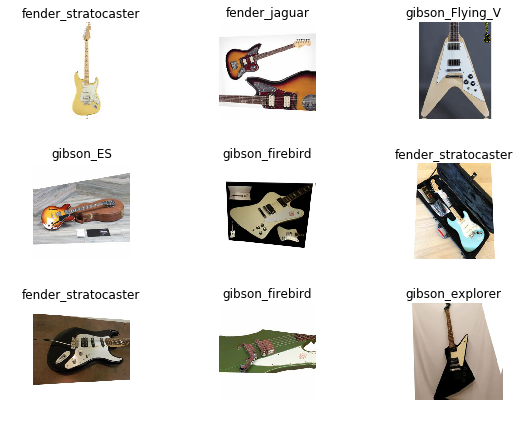

In [9]:
# inspect some images
data.show_batch(rows=3, figsize=(8,6))

# A first model (ResNet34, px=224)
## Training 

We start small. Picture size 224x224px. We can therefore use a larger batch size (64).

In [10]:
data = get_data(src, sz=224, bs=64)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


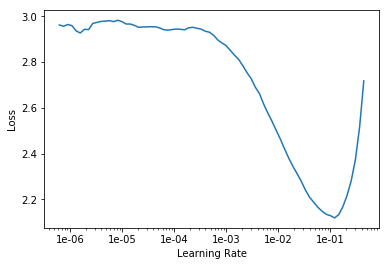

In [11]:
learn = create_cnn(data, models.resnet34, path='.', metrics=error_rate)
learn.lr_find(); 
learn.recorder.plot()

In [13]:
lr = 0.01

In [14]:
learn.fit_one_cycle(5, slice(lr))

Total time: 04:33
epoch  train_loss  valid_loss  error_rate
1      0.879526    0.429882    0.151176    (00:56)
2      0.505392    0.390242    0.131176    (00:54)
3      0.331157    0.229369    0.071176    (00:54)
4      0.233440    0.170554    0.051765    (00:54)
5      0.165632    0.153984    0.047647    (00:54)



In [15]:
learn.save('guitars-v1-11cl-res34-224px-01')

That's pretty good right from the start. But let's unfreeze all layers and fine-tune the model.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


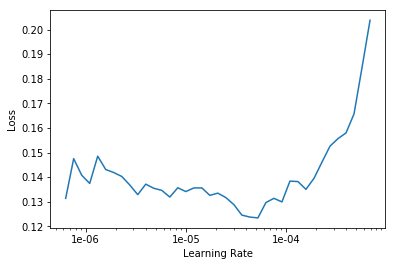

In [17]:
learn.load('guitars-v1-11cl-res34-224px-01')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Total time: 06:20
epoch  train_loss  valid_loss  error_rate
1      0.187636    0.190782    0.060000    (01:16)
2      0.194982    0.161690    0.054118    (01:16)
3      0.120578    0.118841    0.036471    (01:16)
4      0.060915    0.096405    0.029412    (01:16)
5      0.029718    0.088471    0.028235    (01:16)



In [19]:
learn.save('guitars-v1-11cl-res34-224px-02')

## Checking the model status

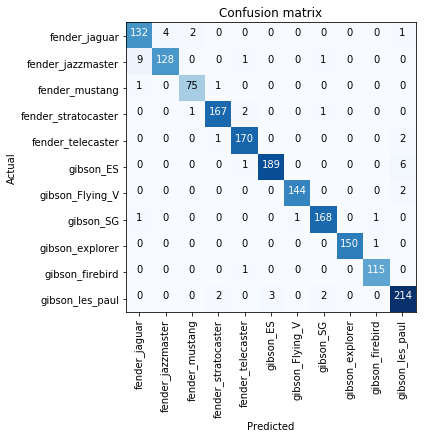

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,6))

In [22]:
display(interp.most_confused(min_val=2))

[('fender_jazzmaster', 'fender_jaguar', 9),
 ('gibson_ES', 'gibson_les_paul', 6),
 ('fender_jaguar', 'fender_jazzmaster', 4),
 ('gibson_les_paul', 'gibson_ES', 3)]

Ok, this already quite amazing. We are at ~97.2% accuracy. Seems the model has a hard time differentiating between a Jaguar and Jazzmaster (who wouldn't they are super similar). Dito for the Gibson ES and Les Paul (here, special models exist lend features from the other model).

## Let's level up: ResNet 50
Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. Later in the course you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network might eat up our GPU memory.

In [24]:
data = get_data(src, sz=224, bs=32)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


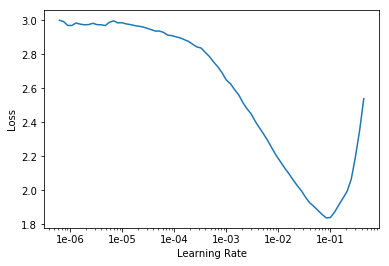

In [15]:
learn = create_cnn(data, models.resnet50, path='.', metrics=error_rate)
learn.freeze()
learn.lr_find(); 
learn.recorder.plot()

In [26]:
lr = 0.01

In [27]:
learn.fit_one_cycle(5, slice(lr))

Total time: 10:25
epoch  train_loss  valid_loss  error_rate
1      0.567226    0.378636    0.137647    (02:11)
2      0.475970    0.239585    0.075882    (02:03)
3      0.330689    0.172150    0.052941    (02:03)
4      0.157123    0.130240    0.038824    (02:03)
5      0.115111    0.117402    0.036471    (02:03)



In [28]:
learn.save('guitars-v1-11cl-res50-224px-01')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


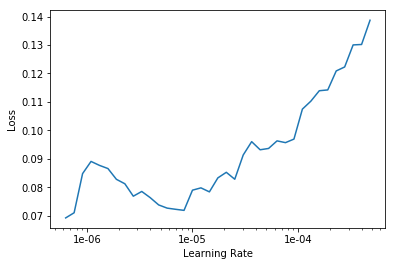

In [29]:
learn.load('guitars-v1-11cl-res50-224px-01')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(5, slice(1e-6, lr/5))

Total time: 13:44
epoch  train_loss  valid_loss  error_rate
1      0.117108    0.123493    0.039412    (02:46)
2      0.161240    0.123812    0.034118    (02:44)
3      0.089996    0.126276    0.038824    (02:44)
4      0.043748    0.088272    0.028824    (02:44)
5      0.031261    0.082933    0.024706    (02:44)



In [31]:
learn.save('guitars-v1-11cl-res50-224px-02')

## Progressive Resizing (224 > 448)

In [16]:
learn.load('guitars-v1-11cl-res50-224px-02')
learn.data = get_data(src, sz=448, bs=16)
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


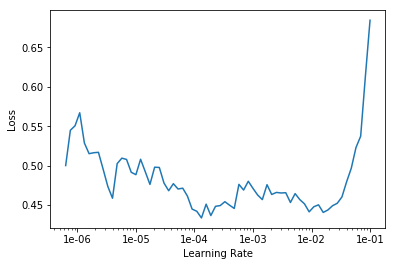

In [17]:
learn.lr_find(); 
learn.recorder.plot()

In [18]:
lr=1e-3

In [19]:
learn.fit_one_cycle(5, slice(lr))

Total time: 37:44
epoch  train_loss  valid_loss  error_rate
1      0.197119    0.094015    0.031176    (07:42)
2      0.111119    0.070475    0.021176    (07:30)
3      0.096168    0.058960    0.018824    (07:30)
4      0.063946    0.053795    0.014706    (07:30)
5      0.067555    0.057556    0.016471    (07:30)



In [20]:
learn.save('guitars-v1-11cl-res50-448px-01')

In [21]:
learn.load('guitars-v1-11cl-res50-448px-01')
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-06, lr/5))

Total time: 49:50
epoch  train_loss  valid_loss  error_rate
1      0.079234    0.061442    0.014706    (10:02)
2      0.071584    0.055586    0.014706    (09:57)
3      0.066293    0.047648    0.011765    (09:57)
4      0.039238    0.045439    0.012941    (09:56)
5      0.033696    0.047318    0.014118    (09:57)



In [22]:
learn.save('guitars-v1-11cl-res50-448px-02')

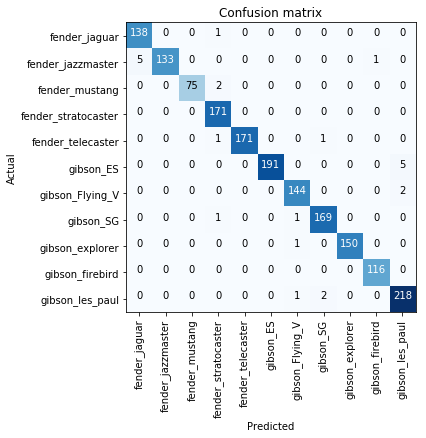

In [25]:
learn.load('guitars-v1-11cl-res50-448px-02')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,6))

In [26]:
interp.most_confused()

[('fender_jazzmaster', 'fender_jaguar', 5),
 ('gibson_ES', 'gibson_les_paul', 5),
 ('fender_mustang', 'fender_stratocaster', 2),
 ('gibson_Flying_V', 'gibson_les_paul', 2),
 ('gibson_les_paul', 'gibson_SG', 2)]

Done! 